# Computer vision: AlexNet, VGG-19, GoogLeNet
Import various modules that we need for this notebook.

In [1]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

Using Theano backend.
/Users/taylor/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib


Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### I. OverFeat adaptation of AlexNet (2012)
An adaptation of the 'fast' model from AlexNet applied to MNIST-10.

In [44]:
model = Sequential()

# Layer 1
model.add(Convolution2D(96, 11, 11, input_shape = (1,28,28), border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Convolution2D(256, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, border_mode='same'))
model.add(Activation('relu'))

# Layer 4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(Activation('relu'))

# Layer 5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Flatten())
model.add(Dense(3072, init='glorot_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 7
model.add(Dense(4096, init='glorot_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8
model.add(Dense(10, init='glorot_normal'))
model.add(Activation('softmax'))

As you can imagine, training this model (even on MNIST-10) is quite time consuming. I'll run just one Epoch with 10 samples to show how it works.

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
model.fit(X_train[:10], Y_train[:10], batch_size=1, nb_epoch=1,
          verbose=1, show_accuracy=True)

Epoch 1/1
10/10 [==============================] - 95s - loss: nan - acc: 0.1000    


The true power of this model really comes out when it is used on a larger corpus of images, such as ILSVRC and MS COCO, with images having a larger spatial size.

### II. VGG-19 Model
Now, let's load the VGG-19 model using pre-trained weights. First, we'll create a keras model as normal:

In [13]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

We then load the weights of the model from a file (you can download this from the course website; it is not small, coming in at about half a gigabyte). We then have to compile the model, even though we have no intention of actually training it. This is because the compilation in part sets the forward propigation code, which we will need to do predictions.

In [14]:
model.load_weights("../../../class_data/keras/vgg19_weights.h5")

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

We will also load some metadata, that gives class labels to the output:

In [15]:
synsets = []
with open("../../../class_data/keras/synset_words.txt", "r") as f:
    synsets += f.readlines()
synsets = [x.replace("\n","") for x in synsets]

Now lets read in an image of a lion:

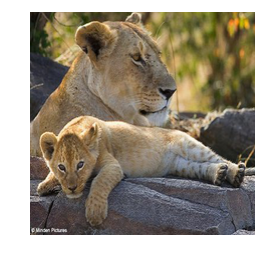

In [27]:
im = Image.open('img/lion.jpg').resize((224, 224), Image.ANTIALIAS)
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(im)
im = np.array(im).astype(np.float32)

# scale the image, according to the format used in training
im[:,:,0] -= 103.939
im[:,:,1] -= 116.779
im[:,:,2] -= 123.68
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)

And now predict the class label from the VGG-19 model:

In [28]:
out = model.predict(im)
for index in np.argsort(out)[0][::-1][:10]:
    print("%01.4f - %s" % (out[0][index], synsets[index].replace("\n","")))

0.3274 - n02129165 lion, king of beasts, Panthera leo
0.2489 - n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
0.2208 - n02128757 snow leopard, ounce, Panthera uncia
0.0753 - n02128385 leopard, Panthera pardus
0.0631 - n02128925 jaguar, panther, Panthera onca, Felis onca
0.0360 - n02117135 hyena, hyaena
0.0091 - n02127052 lynx, catamount
0.0063 - n01882714 koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
0.0024 - n02129604 tiger, Panthera tigris
0.0020 - n01883070 wombat


A relatively impressive result for an out of sample image!

### III. GoogLeNet - Inception Module
An implementation of the Inception module, the basic building block of GoogLeNet (2014). As with OverFeat, I don't have enough compute power here to actually traing the model, but this does serve as a nice example of how to use the graph interface in keras.

In [46]:
model = Graph()
model.add_input(name='n00', input_shape=(1,28,28))

# layer 1
model.add_node(Convolution2D(64,1,1, activation='relu'), name='n11', input='n00')
model.add_node(Flatten(), name='n11_f', input='n11')

model.add_node(Convolution2D(96,1,1, activation='relu'), name='n12', input='n00')

model.add_node(Convolution2D(16,1,1, activation='relu'), name='n13', input='n00')

model.add_node(MaxPooling2D((3,3),strides=(2,2)), name='n14', input='n00')

# layer 2
model.add_node(Convolution2D(128,3,3, activation='relu'), name='n22', input='n12')
model.add_node(Flatten(), name='n22_f', input='n22')

model.add_node(Convolution2D(32,5,5, activation='relu'), name='n23', input='n13')
model.add_node(Flatten(), name='n23_f', input='n23')

model.add_node(Convolution2D(32,1,1, activation='relu'), name='n24', input='n14')
model.add_node(Flatten(), name='n24_f', input='n24')

# output layer
model.add_node(Dense(1024, activation='relu'), name='layer4',
               inputs=['n11_f', 'n22_f', 'n23_f', 'n24_f'], merge_mode='concat')
model.add_node(Dense(10, activation='softmax'), name='layer5', input='layer4')
model.add_output(name='output1',input='layer5')

In [48]:
model.compile(loss={'output1':'categorical_crossentropy'}, optimizer=RMSprop())
model.fit({'n00':X_train[:100], 'output1':Y_train[:100]}, nb_epoch=1, verbose=1)

Epoch 1/1
100/100 [==============================] - 24s - loss: 7.0162


### IV. Batch Normalization
Use the Batch Normalization of: Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015). We'll re-train LeNet-5, but use relu units.

In [6]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (1, 28, 28)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Convolution2D(16, 5, 5, border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Convolution2D(120, 1, 1, border_mode='valid'))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
model.fit(X_train, Y_train, batch_size=32, nb_epoch=20,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 69s - loss: 0.3758 - acc: 0.8819 - val_loss: 0.1097 - val_acc: 0.9652
Epoch 2/20
12896/60000 [=====>........................] - ETA: 54s - loss: 0.1846 - acc: 0.9418

### V. Residual block - as in ResNet (2015)
An example of the residual block used in the pre-print: "Deep Residual Learning for Image Recognition." (2015).

In [36]:
model = Graph()
model.add_input(name='input0', input_shape=(1,28,28))
model.add_node(Flatten(), name='input1', input='input0')
model.add_node(Dense(50),   name='input2', input='input1')

model.add_node(Dense(50, activation='relu'), name='middle1', input='input2')
model.add_node(Dense(50, activation='relu'), name='middle2', input='middle1')

model.add_node(Dense(512, activation='relu'), name='top1',
               inputs=['input2', 'middle2'], merge_mode='sum')
model.add_node(Dense(10, activation='softmax'), name='top2', input='top1')
model.add_output(name='top3',input='top2')

In [37]:
model.compile(loss={'top3':'categorical_crossentropy'}, optimizer=RMSprop())
model.fit({'input0':X_train, 'top3':Y_train}, nb_epoch=25, verbose=1,
          validation_data={'input0':X_test, 'top3':Y_test})

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 3s - loss: 0.3205 - val_loss: 0.1624
Epoch 2/25
60000/60000 [==============================] - 2s - loss: 0.1416 - val_loss: 0.1197
Epoch 3/25
60000/60000 [==============================] - 2s - loss: 0.1025 - val_loss: 0.1044
Epoch 4/25
60000/60000 [==============================] - 2s - loss: 0.0812 - val_loss: 0.0978
Epoch 5/25
60000/60000 [==============================] - 2s - loss: 0.0679 - val_loss: 0.0857
Epoch 6/25
60000/60000 [==============================] - 2s - loss: 0.0574 - val_loss: 0.0819
Epoch 7/25
60000/60000 [==============================] - 2s - loss: 0.0493 - val_loss: 0.1023
Epoch 8/25
60000/60000 [==============================] - 2s - loss: 0.0428 - val_loss: 0.0861
Epoch 9/25
60000/60000 [==============================] - 3s - loss: 0.0373 - val_loss: 0.0948
Epoch 10/25
60000/60000 [==============================] - 2s - loss: 0.0316 - val_loss: 0.0789